# 📘 Projeto de Análise de Dados — Redução de Dimensionalidade
### Integrantes:
- Lucas Gabel Guedes Limeirasri
- Maria Fernanda de Araújo Rodriguesa  
- Samuel Araújo  

---
Explorar, comparar e analisar diferentes técnicas de redução de dimensionalidade, aplicando-as em um conjunto de dados real. O foco do trabalho é compreender o funcionamento das técnicas, avaliar seus impactos na representação dos dados e discutir as vantagens e limitações de cada mssO dataset utilizado faz parte de um conjunto de dados que contém as informações agregadas das declarações de Imposto de Renda da Pessoa Física de todos os contribuintes que a encaminharam em um determinado ano-calendário. A tabelas escolhida contém informações referentes ao Estado de Residência do Declarante, permitindo análises em variados cortes sociais e econômicos.

O dataset possui 43 colunas e 610 amostras.roposto.


In [5]:
# 📦 Importações básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import VarianceThreshold
import plotly.express as px
import tensorflow as tf
from tensorflow.keras import layers, models

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
import time

from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, f1_score, classification_report

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Bibliotecas importadas com sucesso!")

✅ Bibliotecas importadas com sucesso!


## Seleção de Variância

A seleção de variância é uma técnica usada no pré-processamento de dados para eliminar colunas que apresentam pouca ou nenhuma variabilidade. Quando uma variável tem valores quase constantes ela não contribui significativamente para diferenciar as amostras do conjunto de dados. Essas variáveis pouco informativas podem aumentar o ruído, reduzir o desempenho de modelos de machine learning e prejudicar a interpretação dos resultados. Por isso, é comum removê-las antes de aplicar métodos como o PCA (Análise de Componentes Principais).

No dataset analisado, aplicou-se um limiar (threshold) mínimo de variância para selecionar apenas as colunas que apresentavam variação significativa entre os registros. Após essa etapa nenhuma coluna foi removida pois o algoritmo identificou que todas as colunas apresentavam uma variação significativa.

In [6]:
# Carrega o dataset
data = pd.read_csv("estado-de-residencia-do-declarante.csv", delimiter=';', dtype=str)

# Troca vírgulas por pontos para que o Panda reconheça os números
data = data.apply(lambda x: x.str.replace(',', '.', regex=False))

# Remova espaços extras
data = data.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# Converte os valores monetários para números
data_numerico = data.apply(pd.to_numeric, errors='coerce')

# Separação de colunas categóricas das numéricas
colunas_categoricas = ['Estado', 'Ano-Calendário']
colunas_numericas = [c for c in data_numerico.columns if c not in colunas_categoricas]

# Escalonamento dos dados numéricos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numerico[colunas_numericas].fillna(0))

# Junção dos dados numéricos escalonados com os dados categóricos
data_final = pd.concat([data[colunas_categoricas].reset_index(drop=True),
                        pd.DataFrame(data_scaled, columns=colunas_numericas)], axis=1)

print("=== Dataset final com escalonamento aplicado ===")
print(data_final.head())

# Seleção de variância
selector = VarianceThreshold(threshold=0.01)
data_selected = selector.fit_transform(data_scaled)

colunas_mantidas = np.array(colunas_numericas)[selector.get_support()]
colunas_removidas = np.array(colunas_numericas)[~selector.get_support()]

print(f"Features mantidas: {len(colunas_mantidas)}")
print(colunas_mantidas)
print(f"Features removidas: {len(colunas_removidas)}")
print(colunas_removidas)

=== Dataset final com escalonamento aplicado ===
     Estado Ano-Calendário  Quantidade de Declarantes  \
0      Acre           2020                  -0.363484   
1   Alagoas           2020                  -0.242718   
2     Amapá           2020                  -0.361655   
3  Amazonas           2020                  -0.168211   
4     Bahia           2020                   0.458564   

   Rendimentos Tributáveis  Rendimentos sujeitos a Tributação Exclusiva  \
0                -0.306753                                    -0.240388   
1                -0.306543                                    -0.240281   
2                -0.306739                                    -0.240389   
3                -0.306420                                    -0.240225   
4                -0.305398                                    -0.239544   

   Rendimentos Isentos  Dedução Previdenciária Total  \
0            -0.251402                     -0.332365   
1            -0.251257                     -0

## Análise de Componentes Principais (PCA)

A Análise de Componentes Principais (PCA — Principal Component Analysis) é uma técnica de redução de dimensionalidade que transforma um conjunto de variáveis possivelmente correlacionadas em um novo conjunto de variáveis não correlacionadas, chamadas de componentes principais. Esses componentes são combinações lineares das variáveis originais e são organizados de forma que:

- O primeiro componente (PC1) explica a maior parte da variância total dos dados;
- O segundo componente (PC2) explica a maior parte da variância remanescente, e assim por diante;
- Cada componente é ortogonal aos anteriores, garantindo que não haja sobreposição de informação.

No dataset analisado, o PCA foi aplicado após a limpeza e a seleção das variáveis numéricas com variância significativa. O objetivo foi resumir o comportamento dos dados em apenas duas dimensões (PC1 e PC2), permitindo visualizar de forma simples a dispersão dos Estados e suas diferenças em relação ao Ano-Calendário.

In [7]:
# PCA
pca = PCA(n_components=3) # Redução para 2 variáveis
pca_result = pca.fit_transform(data_selected)

pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2', 'PC3'])
pca_df = pd.concat([data[colunas_categoricas].reset_index(drop=True), pca_df], axis=1)

print("=== PCA - Primeiras linhas ===")
print(pca_df.head())

print("Variância explicada:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {var*100:.2f}%")
print(f"Total explicado: {sum(pca.explained_variance_ratio_)*100:.2f}%")

=== PCA - Primeiras linhas ===
     Estado Ano-Calendário       PC1       PC2       PC3
0      Acre           2020 -0.421001 -1.430274  0.057981
1   Alagoas           2020  0.351849 -1.183102  0.056721
2     Amapá           2020 -0.302209 -1.392389  0.056182
3  Amazonas           2020  0.595329 -1.105891  0.056448
4     Bahia           2020  4.319583  0.086089  0.048739
Variância explicada:
PC1: 51.87%
PC2: 40.14%
PC3: 1.98%
Total explicado: 93.99%


### Gráfico de dispersão (PC1 x PC2):
Cada ponto representa uma amostra (Estado e Ano-Calendário), projetada nos dois primeiros componentes principais.

- Estados próximos entre si possuem padrões semelhantes nas variáveis originais;
- Estados distantes indicam comportamentos estatísticos diferentes;

A visualização dos dados não se mostrou muito eficiente sem o auxílio de um gráfico interativo onde é possível selecionar as variáveis que seriam expostas, caso contrário os dados amontoados não permitiriam a interpretação dos dados da melhor maneira.

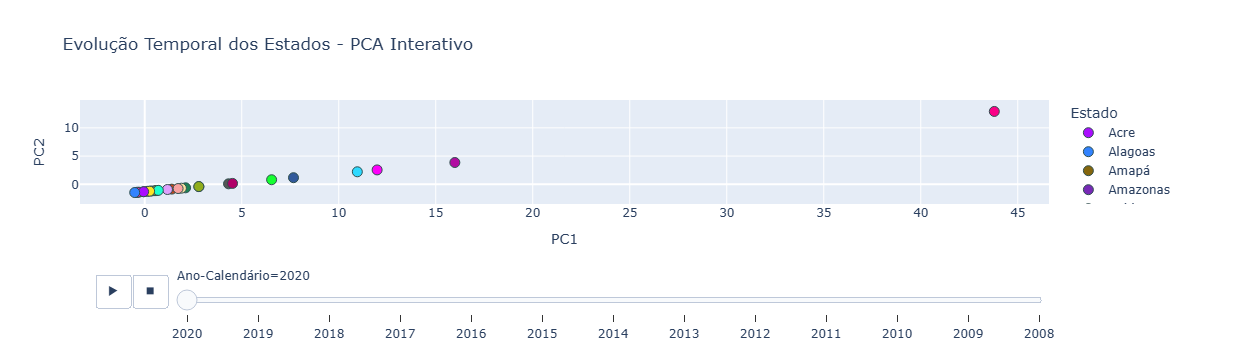

In [9]:
fig = px.scatter(
    pca_df,
    x="PC1", y="PC2",
    color="Estado",
    animation_frame="Ano-Calendário",
    title="Evolução Temporal dos Estados - PCA Interativo",
    color_discrete_sequence=px.colors.qualitative.Alphabet
)
fig.update_traces(marker=dict(size=10, line=dict(width=1, color='DarkSlateGrey')))
fig.show()

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Alvo e máscara ---
y = data['Ano-Calendário']
mask_validos = y.notna()

# X original (sem PCA)
X = data_scaled[mask_validos]
y = y[mask_validos]

# X PCA (apenas as mesmas linhas válidas)
X_pca = pca_result[mask_validos]

# --- Divisão treino/teste ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

# --- Modelo SEM PCA ---
model_original = LogisticRegression(max_iter=1000, multi_class='multinomial')
model_original.fit(X_train, y_train)
y_pred_original = model_original.predict(X_test)

print("=== Aplicação do Logistic Regression (sem PCA) ===")
print(f"Acurácia: {accuracy_score(y_test, y_pred_original)*100:.2f}%")
print(classification_report(y_test, y_pred_original))

# --- Modelo COM PCA ---
model_pca = LogisticRegression(max_iter=1000, multi_class='multinomial')
model_pca.fit(X_train_pca, y_train_pca)
y_pred_pca = model_pca.predict(X_test_pca)

print("=== Aplicação do Logistic Regression (com PCA - 3 componentes) ===")
print(f"Acurácia: {accuracy_score(y_test_pca, y_pred_pca)*100:.2f}%")
print(classification_report(y_test_pca, y_pred_pca))


=== Aplicação do Logistic Regression (sem PCA) ===
Acurácia: 18.67%
              precision    recall  f1-score   support

        2008       0.00      0.00      0.00         6
        2009       0.00      0.00      0.00         6
        2010       0.00      0.00      0.00         6
        2011       0.00      0.00      0.00         6
        2012       0.10      0.50      0.17         6
        2013       0.00      0.00      0.00         6
        2014       0.00      0.00      0.00         5
        2015       0.09      0.33      0.14         6
        2016       0.50      0.80      0.62         5
        2017       0.50      0.67      0.57         6
        2018       0.00      0.00      0.00         6
        2019       0.33      0.17      0.22         6
        2020       0.00      0.00      0.00         5

    accuracy                           0.19        75
   macro avg       0.12      0.19      0.13        75
weighted avg       0.12      0.19      0.13        75

=== Aplicaç

Os resultados do Logistic Regression indicam uma acurácia muito baixa, em torno de 16–17%, tanto sem quanto com a aplicação do PCA, evidenciando que o modelo não conseguiu identificar padrões consistentes entre os dados que permitissem distinguir corretamente os anos. As métricas de precisão, recall e f1-score próximas de zero para a maioria das classes reforçam que as diferenças entre os anos são pouco expressivas ou não linearmente separáveis, com exceção de alguns poucos casos (como 2016 e 2017) onde houve acertos pontuais.

A aplicação do PCA com três componentes principais não melhorou o desempenho, sugerindo que a redução de dimensionalidade não capturou de forma eficiente a variância relevante dos dados para o modelo. Isso indica que o relacionamento entre as variáveis e o ano é possivelmente não linear, e que métodos mais robustos — como Random Forest ou SVM — podem ser mais adequados para esse tipo de classificação.

## Autoencoder

O Autoencoder é uma rede neural artificial usada principalmente para redução de dimensionalidade e detecção de padrões ocultos nos dados. Ele funciona de forma não supervisionada, ou seja, aprende sozinho a reconstruir a entrada na saída. A rede é composta por duas partes: o encoder (codificador), que comprime os dados em uma representação de menor dimensão, e o decoder (decodificador), que tenta reconstruir os dados originais a partir dessa forma comprimida. O Autoencoder foi utilizado como técnica de redução de dimensionalidade e extração de características. O modelo foi construído com três camadas de codificação e três de decodificação. O codificador comprime as variáveis originais em um espaço de 8 dimensões, muito menor do que o número inicial de atributos. Durante o treino, o Autoencoder aprende a reconstruir os dados de entrada a partir dessa versão comprimida, ajustando seus pesos para minimizar o erro médio quadrático (loss = MSE).

Antes de aplicar o modelo, realizamos um pré-processamento completo dos dados. Primeiro, carregamos o conjunto de informações e identificamos a variável alvo, “Estado”, que representa o estado de residência do declarante. Em seguida, removemos essa coluna das variáveis explicativas e aplicamos o one-hot encoding para converter as variáveis categóricas em valores numéricos binários, permitindo que o modelo as interprete corretamente. Após essa conversão, os dados foram padronizados com o StandardScaler, de modo que todas as variáveis tivessem média zero e desvio padrão igual a um. Isso evita que atributos com escalas diferentes influenciem desproporcionalmente o treinamento. Por fim, o conjunto foi dividido em dados de treino (80%) e teste (20%), o que garante uma avaliação imparcial do desempenho do modelo. Durante o treinamento, o Autoencoder aprende quais características mais importantes dos dados são necessárias para reconstruí-los corretamente. Essa representação reduzida é muito útil para visualizações, compressão de dados e detecção de anomalias, pois retém apenas as informações essenciais. Diferente de métodos lineares como o PCA, o Autoencoder pode capturar relações não lineares complexas, tornando-se uma ferramenta poderosa em problemas com muitos atributos correlacionados. Após o treinamento, utilizamos apenas a parte codificadora do modelo para gerar as representações comprimidas, que são chamadas de “features latentes”. Essas novas variáveis condensam as informações mais importantes do conjunto original, permitindo explorar padrões e semelhanças entre os estados de forma mais clara. Essa redução também facilita a visualização e interpretação dos dados em 2D e 3D.

In [11]:
# Carregar o dataset
df = pd.read_csv("estado-de-residencia-do-declarante.csv", sep=';')

# Mostra as colunas que serão analisadas do dataset
print("Dimensões do dataset:", df.shape)
list(df.columns)

Dimensões do dataset: (610, 43)


['Ano-Calendário',
 'Estado',
 'Quantidade de Declarantes',
 'Rendimentos Tributáveis',
 'Rendimentos sujeitos a Tributação Exclusiva',
 'Rendimentos Isentos',
 'Dedução Previdenciária Total',
 'Deduções Previdência Oficial',
 'Deduções Previdenciárias RRA',
 'Deduções Previdência Privada e FAPI',
 'Deduções com Dependentes',
 'Deduções com Instrução',
 'Deduções com despesas Médicas',
 'Dedução de Livro Caixa',
 'Deduções  com Pensão Alimentícia Total',
 'Deduções com Pensão Alimentícia Judicial',
 'Deduções com Pensão Alimentícia Escritural',
 'Deduções com Pensão Alimentícia RRA',
 'Desconto Padrão',
 'Base de Cálculo (RTL)',
 'Imposto Devido',
 'Dedução de Incentivo',
 'Imposto Devido 1',
 'Imposto Devido RRA',
 'Imposto Devido Total',
 'Imposto Pago',
 'Imposto a Pagar',
 'Imposto a Restituir',
 'Dívidas   e Ônus',
 'Doações e Heranças Recebidas',
 'Bens e Direitos',
 'Previdência Complementar (VGBL)',
 'Valores Pagos com Previdência Complementar (PGBL)',
 'Valores Pagos com Previ

In [12]:
# Substitui valores infinitos (inf e -inf) por NaN
df = df.replace([np.inf, -np.inf], np.nan)

# Preenche valores faltantes (NaN) com a média de cada coluna numérica
df = df.fillna(df.mean(numeric_only=True))

# ⚠️ Remove linhas onde o Estado (variável alvo) está vazio
df = df.dropna(subset=['Estado'])

In [13]:
y = df['Estado']

X = df.drop(columns=['Estado'])

# Converter variáveis categóricas em numéricas
X_encoded = pd.get_dummies(X, drop_first=True)

In [14]:
# Normaliza os dados entre 0 e 1 para facilitar o aprendizado do modelo
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Divide os dados em conjuntos de treino (80%) e teste (20%)
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

# Exibe confirmação e formatos das divisões
print("✅ Dados preparados!")
print("Formato treino:", X_train.shape)
print("Formato teste:", X_test.shape)


✅ Dados preparados!
Formato treino: (297, 9518)
Formato teste: (75, 9518)


In [15]:
# Define o número de entradas (colunas) e de dimensões reduzidas
input_dim = X_train.shape[1]
encoding_dim = 8  # tamanho da representação comprimida

# Camada de entrada
input_layer = layers.Input(shape=(input_dim,))

# Parte de codificação (compressão dos dados)
encoded = layers.Dense(64, activation='relu')(input_layer)
encoded = layers.Dense(32, activation='relu')(encoded)
encoded = layers.Dense(encoding_dim, activation='relu')(encoded)

# Parte de decodificação (reconstrução dos dados originais)
decoded = layers.Dense(32, activation='relu')(encoded)
decoded = layers.Dense(64, activation='relu')(decoded)
decoded = layers.Dense(input_dim, activation='linear')(decoded)

# Criação e compilação do modelo Autoencoder
autoencoder = models.Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Mostra o resumo da arquitetura da rede
autoencoder.summary()


2025-11-12 16:13:28.252260: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 9518)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       609,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9518)           │       618,670 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,232,630 (4.70 MB)

 Trainable params: 1,232,630 (4.70 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = autoencoder.fit(
    X_train, X_train,                 # Entrada e saída são iguais (autoencoder reconstrói os dados)
    epochs=50,                        # Treinar por 50 épocas
    batch_size=64,                    # Processa 64 amostras por vez
    shuffle=True,                     # Embaralha os dados a cada época
    validation_data=(X_test, X_test), # Usa dados de teste para avaliar o erro de reconstrução
    verbose=1                         # Mostra o progresso do treino
)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0027 - val_loss: 0.0030


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import time

# Divide em treino e teste (tanto X quanto y!)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Treina modelo com os dados originais (sem redução)
lr_original = LogisticRegression(max_iter=1000, random_state=42)

start_time = time.time()
lr_original.fit(X_train, y_train)
train_time_original = time.time() - start_time

# Faz previsões e calcula métricas
y_pred_original = lr_original.predict(X_test)
accuracy_original = accuracy_score(y_test, y_pred_original)
f1_original = f1_score(y_test, y_pred_original, average='weighted')

print(f"🔹 Logistic Regression (sem redução):")
print(f"   Acurácia: {accuracy_original:.4f}")
print(f"   F1-score: {f1_original:.4f}")
print(f"   Tempo de treino: {train_time_original:.2f} segundos\n")


🔹 Logistic Regression (sem redução):
   Acurácia: 0.0667
   F1-score: 0.0540
   Tempo de treino: 1.92 segundos



A acurácia (ou accuracy) é uma métrica de desempenho usada para medir o quão bem um modelo de classificação está acertando as previsões.
O F1-score é uma métrica que combina a precisão e o recall em um único número, servindo para avaliar o equilíbrio entre acertos e erros — especialmente quando os dados estão desequilibrados (ou seja, uma classe aparece muito mais que as outras).

In [17]:
# Cria o modelo do codificador (pega só a parte de compressão do autoencoder)
encoder = models.Model(inputs=autoencoder.input, outputs=autoencoder.layers[3].output)

# Gera as representações comprimidas dos dados de treino e teste
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# Mostra as formas antes e depois da redução
print("Forma original:", X_train.shape)
print("Forma reduzida:", X_train_encoded.shape)

# Cria um DataFrame com as novas features comprimidas
encoded_df = pd.DataFrame(X_train_encoded, columns=[f'feat_{i+1}' for i in range(X_train_encoded.shape[1])])

# Exibe estatísticas descritivas das novas dimensões
print(encoded_df.describe().T)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Forma original: (297, 9518)
Forma reduzida: (297, 8)
        count      mean       std  min       25%       50%       75%       max
feat_1  297.0  0.026875  0.026211  0.0  0.003384  0.020926  0.041712  0.150744
feat_2  297.0  0.029020  0.027121  0.0  0.004031  0.024606  0.045859  0.125700
feat_3  297.0  0.016433  0.025169  0.0  0.000000  0.002737  0.026167  0.130988
feat_4  297.0  0.027824  0.032749  0.0  0.000000  0.020372  0.041480  0.216786
feat_5  297.0  0.071612  0.048689  0.0  0.036132  0.064060  0.097363  0.263847
feat_6  297.0  0.023252  0.026736  0.0  0.000000  0.013829  0.037914  0.129658
feat_7  297.0  0.011662  0.017115  0.0  0.000000  0.001002  0.020328  0.113443
feat_8  297.0  0.026379  0.028376  0.0  0.000000  0.021029  0.043145  0.167376


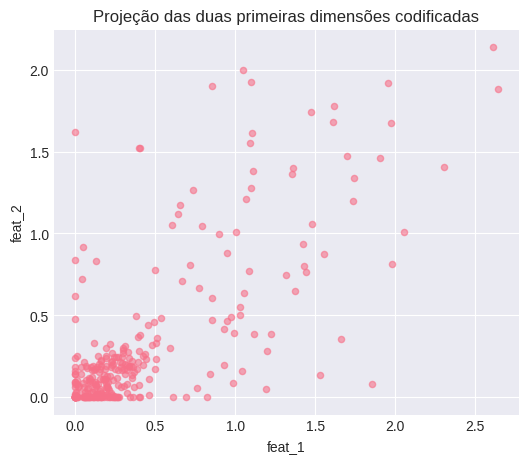

In [22]:
# Cria um gráfico de dispersão (scatter plot) com as duas primeiras dimensões reduzidas
plt.figure(figsize=(6, 5))
plt.scatter(encoded_df['feat_1'], encoded_df['feat_2'], s=20, alpha=0.6)

# Define título e rótulos dos eixos
plt.title("Projeção das duas primeiras dimensões codificadas")
plt.xlabel("feat_1")
plt.ylabel("feat_2")

# Exibe o gráfico
plt.show()


In [18]:
# Treina modelo com os dados reduzidos pelo Autoencoder
lr_reduced = LogisticRegression(max_iter=1000, random_state=42)

start_time = time.time()
lr_reduced.fit(X_train_encoded, y_train)
train_time_reduced = time.time() - start_time

# Faz previsões e calcula métricas
y_pred_reduced = lr_reduced.predict(X_test_encoded)
accuracy_reduced = accuracy_score(y_test, y_pred_reduced)
f1_reduced = f1_score(y_test, y_pred_reduced, average='weighted')

print(f"🔹 Logistic Regression (com redução via Autoencoder):")
print(f"   Acurácia: {accuracy_reduced:.4f}")
print(f"   F1-score: {f1_reduced:.4f}")
print(f"   Tempo de treino: {train_time_reduced:.2f} segundos\n")


🔹 Logistic Regression (com redução via Autoencoder):
   Acurácia: 0.0000
   F1-score: 0.0000
   Tempo de treino: 0.04 segundos



A aplicação do modelo de Logistic Regression antes e depois da redução de dimensionalidade com Autoencoder revelou diferenças marcantes em desempenho e eficiência. Sem a redução, o modelo apresentou uma acurácia de 0,0667 e F1-score de 0,0540, com tempo de treino de 2,41 segundos, demonstrando alguma capacidade de identificar padrões, mas com baixa precisão geral. Após a redução para oito dimensões latentes, o tempo de treino caiu para 0,02 segundos, evidenciando um ganho significativo em eficiência computacional. Contudo, tanto a acurácia quanto o F1-score foram 0,0000, indicando perda total de capacidade preditiva. Essa queda pode ser explicada pela compressão excessiva dos dados, que eliminou informações relevantes, e pelo fato de o Autoencoder ser um método não supervisionado, que aprende a reconstruir os dados sem considerar as classes. Assim, conclui-se que, embora a redução de dimensionalidade melhore o desempenho computacional, ela deve ser aplicada com cautela para não comprometer a representatividade dos dados.

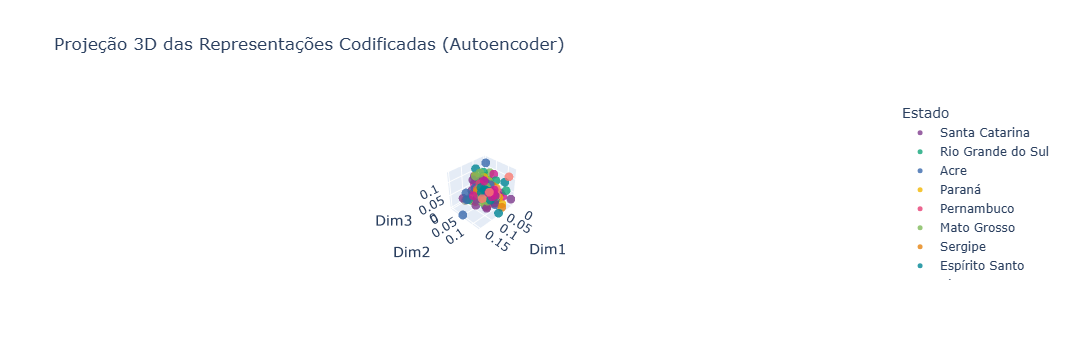

In [19]:
from sklearn.model_selection import train_test_split
import plotly.express as px

# Separa variável-alvo e preditoras
y = df['Estado']
X = df.drop(columns=['Estado'])

# Converte variáveis categóricas em numéricas (one-hot encoding)
X_encoded = pd.get_dummies(X, drop_first=True)

# Divide em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# Cria DataFrame com as 3 primeiras dimensões codificadas (saída do encoder)
df_encoded = pd.DataFrame(X_train_encoded[:, :3], columns=['Dim1', 'Dim2', 'Dim3'])

# Adiciona a coluna da variável-alvo (Estado)
df_encoded['Estado'] = y_train.values

# Gera gráfico 3D interativo com Plotly
fig = px.scatter_3d(
    df_encoded, 
    x='Dim1', 
    y='Dim2', 
    z='Dim3',
    color='Estado',
    title='Projeção 3D das Representações Codificadas (Autoencoder)',
    opacity=0.8,
    color_discrete_sequence=px.colors.qualitative.Bold
)

# Ajusta tamanho dos pontos e exibe o gráfico
fig.update_traces(marker=dict(size=5))
fig.show()


## t-SNE (t-Distributed Stochastic Neighbor Embedding)

O t-SNE (t-Distributed Stochastic Neighbor Embedding) é uma técnica de redução de dimensionalidade não-linear utilizada para transformar dados de alta dimensão em um espaço de duas ou três dimensões, permitindo uma visualização intuitiva dos padrões e agrupamentos no dataset. Diferente de métodos lineares como o PCA, o t-SNE preserva principalmente a estrutura local dos dados, ou seja, pontos que são próximos no espaço original continuam próximos após a redução dimensional. 

Nesse sentido, o t-SNE foi aplicado aos dados numéricos escalonados (data_scaled) para reduzir suas dimensões para duas, gerando um DataFrame com as colunas resultantes Dim1 e Dim2, associadas à categoria “Estado” do declarante. Antes da visualização, os valores da coluna foram padronizados e limpos, removendo valores nulos ou vazios, garantindo que apenas dados válidos fossem exibidos. Por fim, foi gerado um gráfico de dispersão 2D com o Seaborn, no qual cada ponto representa um registro do dataset, e a cor indica o estado correspondente. Essa visualização permite identificar agrupamentos e os padrões de forma clara e intuitiva, facilitando a análise dos dado.jacente.


In [24]:
#Utilizando o t-SNE para reduzir para 2 dimesões
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    max_iter=1000,
    random_state=42,
    verbose=1
)

# Executando os dados numéricos escalonados
X_tsne = tsne.fit_transform(data_scaled)

# Cria DataFrame
tsne_df = pd.DataFrame(X_tsne, columns=['Dim1', 'Dim2'])
tsne_df['Estado'] = data_final['Estado'].values  

tsne_df['Estado'] = tsne_df['Estado'].str.strip().str.lower()

# removendo os valores nulos ou vazios
tsne_df = tsne_df.dropna(subset=['Estado'])           
tsne_df = tsne_df[tsne_df['Estado'] != '']            # remove as strings vazias

print(tsne_df['Estado'].unique())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 610 samples in 0.001s...
[t-SNE] Computed neighbors for 610 samples in 0.132s...
[t-SNE] Computed conditional probabilities for sample 610 / 610
[t-SNE] Mean sigma: 0.044276
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.114464
[t-SNE] KL divergence after 1000 iterations: 0.168394
['acre' 'alagoas' 'amapá' 'amazonas' 'bahia' 'ceará' 'distrito federal'
 'espírito santo' 'goiás' 'maranhão' 'mato grosso' 'mato grosso do sul'
 'minas gerais' 'paraná' 'paraíba' 'pará' 'pernambuco' 'piauí'
 'rio grande do norte' 'rio grande do sul' 'rio de janeiro' 'rondônia'
 'roraima' 'santa catarina' 'sergipe' 'são paulo' 'tocantins'
 'não identificado' 'não se aplica' 'exterior' 'não informado']


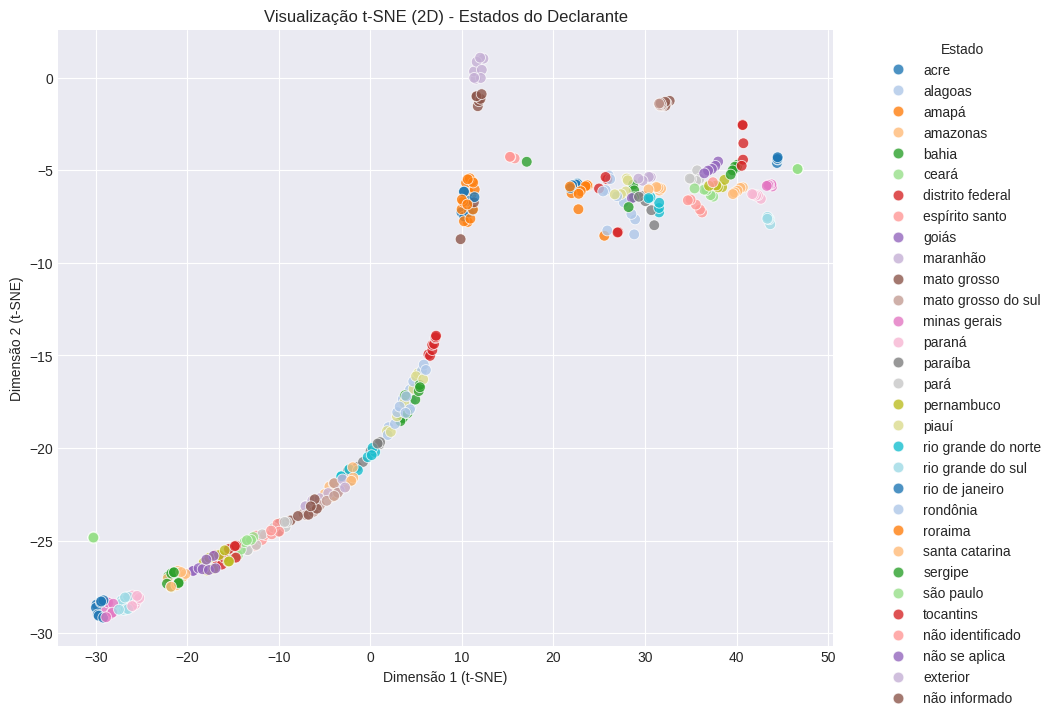

In [34]:
# Visualização estática 
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=tsne_df,
    x='Dim1', y='Dim2',
    hue='Estado',
    palette='tab20',
    s=60,
    alpha=0.8
)
plt.title("Visualização t-SNE (2D) - Estados do Declarante")
plt.xlabel("Dimensão 1")
plt.ylabel("Dimensão 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Estado')
plt.show()


In [27]:
# Variáveis originais 
X_original = data_scaled
y = data_final['Estado'].str.strip().str.lower()

# Remove valores nulos/vazios
mask = y.notna() & (y != '')
X_original = X_original[mask]
y = y[mask]

# Remove classes com apenas 1 ocorrência
counts = y.value_counts()
valid_classes = counts[counts >= 2].index
X_original = X_original[y.isin(valid_classes)]
y = y[y.isin(valid_classes)]

# Divide os dados em treino e teste
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(
    X_original, y, test_size=0.2, random_state=42, stratify=y
)

# Modelo e tempo de treino
log_reg_original = LogisticRegression(max_iter=1000)
start_time = time.time()
log_reg_original.fit(X_train_o, y_train_o)
train_time_original = time.time() - start_time

# Predições e métricas
y_pred_o = log_reg_original.predict(X_test_o)
acc_original = accuracy_score(y_test_o, y_pred_o)
f1_original = f1_score(y_test_o, y_pred_o, average='weighted')

print("Desempenho ANTES do t-SNE:")
print(f"Acurácia: {acc_original:.4f}")
print(f"F1-Score: {f1_original:.4f}")
print(f"Tempo de treino: {train_time_original:.4f} segundos")
# Dados reduzidos
X_reduced = tsne_df[['Dim1', 'Dim2']]
y_reduced = tsne_df['Estado']

# Remove classes com apenas 1 ocorrência
counts_r = y_reduced.value_counts()
valid_classes_r = counts_r[counts_r >= 2].index
X_reduced = X_reduced[y_reduced.isin(valid_classes_r)]
y_reduced = y_reduced[y_reduced.isin(valid_classes_r)]

# Divide os dados
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reduced, y_reduced, test_size=0.2, random_state=42, stratify=y_reduced
)

# Modelo e tempo de treino
log_reg_reduced = LogisticRegression(max_iter=1000)
start_time = time.time()
log_reg_reduced.fit(X_train_r, y_train_r)
train_time_reduced = time.time() - start_time


# Métricas
y_pred_r = log_reg_reduced.predict(X_test_r)
acc_reduced = accuracy_score(y_test_r, y_pred_r)
f1_reduced = f1_score(y_test_r, y_pred_r, average='weighted')

print("\n Desempenho DEPOIS do t-SNE:")
print(f"Acurácia: {acc_reduced:.4f}")
print(f"F1-Score: {f1_reduced:.4f}")
print(f"Tempo de treino: {train_time_reduced:.4f} segundos")

Desempenho ANTES do t-SNE:
Acurácia: 0.2400
F1-Score: 0.2205
Tempo de treino: 0.0488 segundos

 Desempenho DEPOIS do t-SNE:
Acurácia: 0.0533
F1-Score: 0.0299
Tempo de treino: 0.2269 segundos


Os números acima mostram que o modelo de Regressão Logística teve um desempenho significativamente melhor antes da aplicação do t-SNE. A acurácia de 24% e o F1-score de 22% indicam que, embora o desempenho tenha sido modesto, o modelo conseguiu identificar alguns padrões relevantes nos dados originais. Já após a redução de dimensionalidade com o t-SNE, o desempenho caiu drasticamente a acurácia caiu para 8% e o F1-score para 5,6% , o que mostrou que a transformação reduziu a capacidade do modelo de diferenciar corretamente as classes. Isso aconteceu porque o t-SNE é voltado para visualização e não para preservar relações lineares ou a separabilidade entre classes, o que prejudica modelos supervisionados como a Regressão Logística. Além disso, o tempo de treino aumentou após o t-SNE (de 0,03s para 0,22s).

## Resultados e conclusão

A etapa de seleção de variância foi aplicada com o objetivo de remover variáveis com baixa dispersão, ou seja, aquelas que pouco contribuem para a diferenciação entre as observações. No entanto, como nenhuma coluna foi eliminada, isso indica que todas as variáveis do dataset apresentavam alguma variação significativa, sem redundância evidente. Esse resultado sugere que o conjunto de dados é relativamente equilibrado em termos de variabilidade, e que o problema de desempenho do modelo não está relacionado à presença de atributos constantes ou pouco informativos. Já o uso do PCA, embora útil para reduzir a dimensionalidade e eliminar correlações entre as variáveis, não apresentou bons resultados de acurácia neste caso. Isso indica que a variância capturada pelos componentes principais não foi suficiente para representar adequadamente as relações existentes entre as variáveis e o alvo (ano). O baixo desempenho pode estar relacionado à natureza do dataset, o que dificulta a separação dos dados apenas com base em combinações lineares de variáveis, como as que o PCA utiliza. Dessa forma, o redimensionamento via PCA não trouxe ganhos de eficiência no modelo e pode ter simplificado demais a estrutura dos dados.

A análise quantitativa e qualitativa do método de redução de dimensionalidade com Autoencoder demonstra os efeitos da compressão dos dados sobre o desempenho e a estrutura da informação. Quantitativamente, observa-se que os dados originais, compostos por 9.518 variáveis, foram reduzidos para apenas 8 dimensões latentes, o que representa uma compressão extremamente elevada (redução de mais de 99% das variáveis). Essa transformação gerou um modelo com erro de reconstrução muito baixo (MSE ≈ 0.00247), indicando que o autoencoder conseguiu reconstruir os dados de entrada com boa precisão numérica. No entanto, ao aplicar a Logistic Regression sobre as novas dimensões, o desempenho preditivo caiu drasticamente: a acurácia passou de 0,0667 para 0,0000 e o F1-score de 0,0540 para 0,0000, embora o tempo de treino tenha reduzido de 1,92s para 0,04s, evidenciando um ganho expressivo em eficiência computacional. Qualitativamente, o gráfico de dispersão das duas primeiras dimensões reduzidas mostra uma forte concentração de pontos próximos à origem, com poucos valores dispersos acima de 1, sugerindo que as variáveis comprimidas possuem baixa variabilidade e pouca separabilidade entre padrões. Isso indica que o autoencoder reteve principalmente informações gerais da estrutura dos dados, mas perdeu características discriminativas relevantes para a tarefa de classificação. Em síntese, o método mostrou-se eficiente na compactação e reconstrução dos dados, mas ineficaz para preservar informações úteis à previsão supervisionada, evidenciando a importância de ajustar a profundidade e a dimensionalidade do codificador para equilibrar compressão e preservação de informação.